<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [ ]:
# Set your student number
student_number = 99102072
Name = 'Omid'
Last_Name = 'Keshavarz'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

## Importing Libraries

In [ ]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [ ]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [78]:
## FILL HERE
#Set the input dim to number of pixels of fashionMnist pictures
input_dim = 784
num_classes = 10

In [79]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

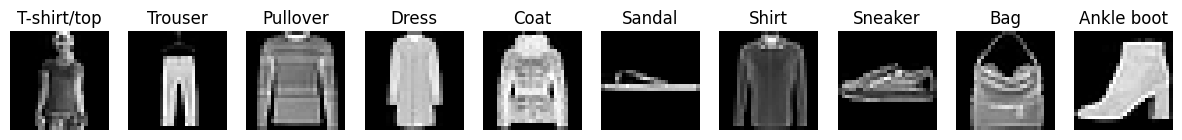

In [ ]:
#visualize 1 random image from each class of FashionMNIST by using plt.subplots
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Find a random image for each class
num_classes = len(class_names)
fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

for i in range(num_classes):
  # Filter images for the current class
  class_indices = np.where(train_labels == i)[0]
  random_index = np.random.choice(class_indices)
  image = train_images[random_index]

  # Display the image
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(class_names[i])
  axes[i].axis('off')

plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [93]:
def add_linear_layer(parameters, shape, device, layer_idx):
    w_key = f'w{layer_idx+1}'
    b_key = f'b{layer_idx+1}'
    parameters[w_key] = torch.randn(shape[0], shape[1], requires_grad=True, device=device) * 0.01
    parameters[b_key] = torch.zeros(shape[1], requires_grad=True, device=device)



Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [94]:
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

# Check the keys in parameters to verify
print(parameters.keys())

dict_keys(['w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4', 'w5', 'b5'])


## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [91]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming device is set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def affine_forward(x, w, b):
    N = x.shape[0]  # batch size
    x_reshaped = x.view(N, -1)  # Flatten the input if necessary
    out = x_reshaped @ w + b
    cache = (x, w, b)
    return out, cache


def relu(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = torch.maximum(torch.tensor(0, dtype=x.dtype), x)
    cache = x
    return out, cache


Function `model` returns output of the whole model for the input `x` using the parameters:

In [73]:
import torch

def model(x: torch.Tensor, parameters, num_layers):
    """
    Implements a neural network with multiple layers.

    Inputs:
    - x: Input tensor of shape (B, D_in), where B is the batch size and D_in is the input dimension.
    - parameters: A dictionary containing the weights and biases for each layer.
    - num_layers: The number of layers in the neural network.

    Returns:
    - output: The output tensor of the network.
    """
    # Number of batches
    B = x.shape[0]
    x = x.view(B, -1)

    for i in range(num_layers):
        w = parameters[f'w{i+1}']
        b = parameters[f'b{i+1}']

        x, _ = affine_forward(x, w, b)

        if i < num_layers - 1:  # Apply ReLU activation to all layers except the last one
            x, _ = relu(x)

    output = x
    return output


Implementing cross entropy loss:

In [102]:
def cross_entropy_loss(scores, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - scores: Input data, of shape (N, C) where scores[i, j] is the score for the j-th class
      for the i-th input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for scores[i] and 0 <= y[i] < C

    Returns a tensor giving the loss.
    """
    # Number of samples
    N = scores.shape[0]

    # Shift the scores for numerical stability
    shifted_scores = scores - torch.max(scores, dim=1, keepdim=True).values

    # Compute the class probabilities
    exp_scores = torch.exp(shifted_scores)
    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)

    # Compute the loss
    correct_logprobs = -torch.log(probs[torch.arange(N), y])
    loss = torch.sum(correct_logprobs) / N

    return loss



Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [99]:
import torch
from typing import Dict

def sgd_optimizer(parameters, learning_rate):
    with torch.no_grad():
        for param in parameters.values():
            if param.grad is not None:
                param -= learning_rate * param.grad
                param.grad.zero_()

Training functions:

In [101]:
import torch
import numpy as np

def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    """
    Computes the accuracy of predictions.

    Inputs:
    - y_pred: A numpy array of predicted labels
    - y_true: A numpy array of true labels

    Returns:
    - acc: The accuracy as a float
    """
    acc = np.mean(y_pred == y_true)
    return acc

def train(train_loader, parameters, learning_rate=0.001, epoch=None):
    train_loss = 0
    N_train = len(train_loader.dataset)
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters, num_layers)

        loss = cross_entropy_loss(p, y)
        loss.backward()

        sgd_optimizer(parameters, learning_rate)

        # Clear the gradients after updating the parameters
        for param in parameters.values():
            if param.grad is not None:
                param.grad.zero_()

        train_loss += loss.item()

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(torch.tensor(Y_pred), torch.tensor(Y))
    print(f'Epoch {epoch}, Train Loss: {train_loss / len(train_loader)}, Train Accuracy: {acc}')
    return train_loss / len(train_loader), acc


def validate(loader, epoch=None, set_name=None):
    '''
    Validates the model on the given data loader.

    Inputs:
    - loader: DataLoader for validation/test data
    - epoch: Current epoch number
    - set_name: Name of the dataset (e.g., 'Validation', 'Test')

    Returns:
    - total_loss: The average loss over the dataset
    - acc: The accuracy over the dataset
    '''
    total_loss = 0
    N = len(loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    Y = []
    Y_pred = []

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            p = model(x, parameters)

            # Compute loss
            loss, _ = cross_entropy_loss(p, y)
            total_loss += loss.item()

            # Store predictions and true labels
            y_pred = p.argmax(dim=-1)
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())

            print(f'Epoch [{epoch}], Batch [{i}], Loss: {loss.item()}')

    total_loss /= len(loader)
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc


In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [ ]:
import matplotlib.pyplot as plt

def train_model(dataloaders, num_epochs, parameters, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        train_loss, train_acc = train(train_loader, parameters, learning_rate, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        test_loss, test_acc = validate(test_loader, parameters, epoch, 'Test')
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

    # Plot the loss history of training and test sets
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()

    # Plot the accuracy history of training and test sets
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()

    plt.show()




In [103]:
train_model([train_loader, test_loader], num_epochs=25, parameters=parameters, learning_rate=0.005)

Epoch 1/25
----------
torch.Size([64, 784])
torch.Size([784, 512])
torch.Size([64, 512])
torch.Size([512, 256])
torch.Size([64, 256])
torch.Size([256, 128])
torch.Size([64, 128])
torch.Size([128, 64])
torch.Size([64, 64])
torch.Size([64, 10])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
print(f'Final test accuracy: {test_accuracies[-1]}')

## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

In [ ]:
## FILL HERE